In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.models import Model

import warnings
warnings.filterwarnings('ignore')

In [69]:
df = pd.read_csv('cryptocurrency_pred.csv')

In [70]:
print(df.head())
print("\nShape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

         Date        Close          High          Low          Open  \
0  2018-02-01  9170.540039  10288.799805  8812.280273  10237.299805   
1  2018-02-02  8830.750000   9142.280273  7796.490234   9142.280273   
2  2018-02-05  6955.270020   8364.839844  6756.680176   8270.540039   
3  2018-02-06  7754.000000   7850.700195  6048.259766   7051.750000   
4  2018-02-07  7621.299805   8509.110352  7236.790039   7755.490234   

        Volume  value value_classification   timestamp  time_until_update  \
0   9959400448     30                 Fear  1517443200                NaN   
1  12726899712     15         Extreme Fear  1517529600                NaN   
2   9285289984     11         Extreme Fear  1517788800                NaN   
3  13999800320      8         Extreme Fear  1517875200                NaN   
4   9169280000     36                 Fear  1517961600                NaN   

   ...         loss  avg_gain  avg_loss  rs  RSI  MA20  stddev  UpperBand  \
0  ...    -0.000000       NaN    

In [71]:
df = df.drop(columns=['time_until_update'])

In [72]:
print(df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'value',
       'value_classification', 'timestamp', 'US Dollar Index',
       'Federal Funds Rate', 'SMA50', 'SMA200', 'delta', 'gain', 'loss',
       'avg_gain', 'avg_loss', 'rs', 'RSI', 'MA20', 'stddev', 'UpperBand',
       'LowerBand', 'Daily_Return'],
      dtype='object')


In [73]:
df[['SMA50', 'SMA200', 'MA20']] = df[['SMA50', 'SMA200', 'MA20']].fillna(0)

In [74]:
df['delta'] = df['Close'].diff()
df['Daily_Return'] = df['Close'].pct_change()

df['delta'].fillna(0, inplace=True)
df['Daily_Return'].fillna(0, inplace=True)

In [75]:
df[['avg_gain', 'avg_loss', 'rs', 'RSI']] = df[['avg_gain', 'avg_loss', 'rs', 'RSI']].bfill()

df[['stddev', 'UpperBand', 'LowerBand']] = df[['stddev', 'UpperBand', 'LowerBand']].fillna(0)

Top correlations with Close:
 Close                 1.000000
High                  0.999442
Low                   0.999307
Open                  0.998555
MA20                  0.989162
UpperBand             0.988977
LowerBand             0.977902
SMA50                 0.967654
SMA200                0.890860
avg_gain              0.819176
timestamp             0.788282
stddev                0.748117
avg_loss              0.729781
Volume                0.557710
value                 0.382091
Federal Funds Rate    0.371965
gain                  0.366122
US Dollar Index       0.355654
loss                  0.318833
RSI                   0.071099
delta                 0.047321
Daily_Return          0.022740
rs                   -0.011016
Name: Close, dtype: float64


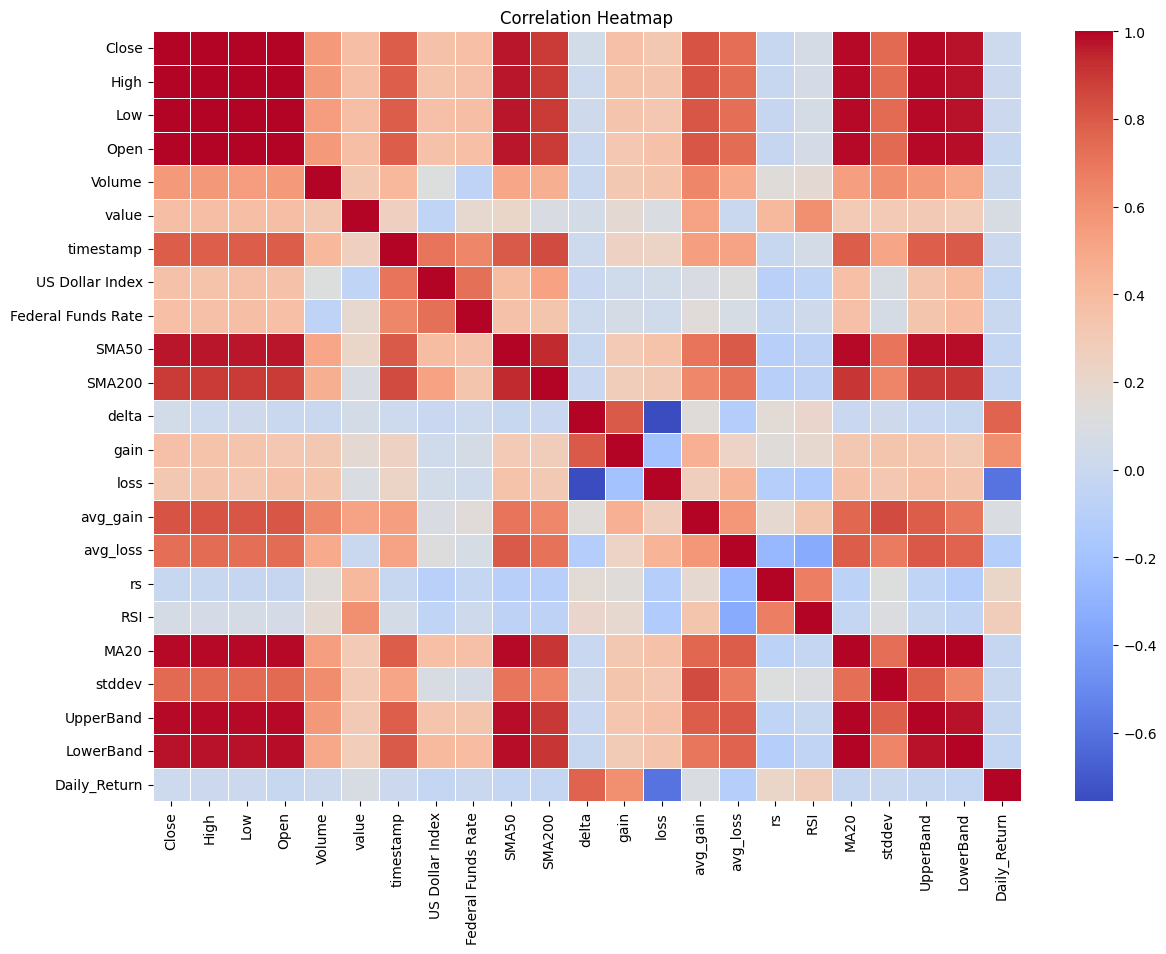

In [76]:
corr_matrix = df.corr(numeric_only=True)

# Display top correlations with 'Close'
close_corr = corr_matrix['Close'].sort_values(ascending=False)
print("Top correlations with Close:\n", close_corr)

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


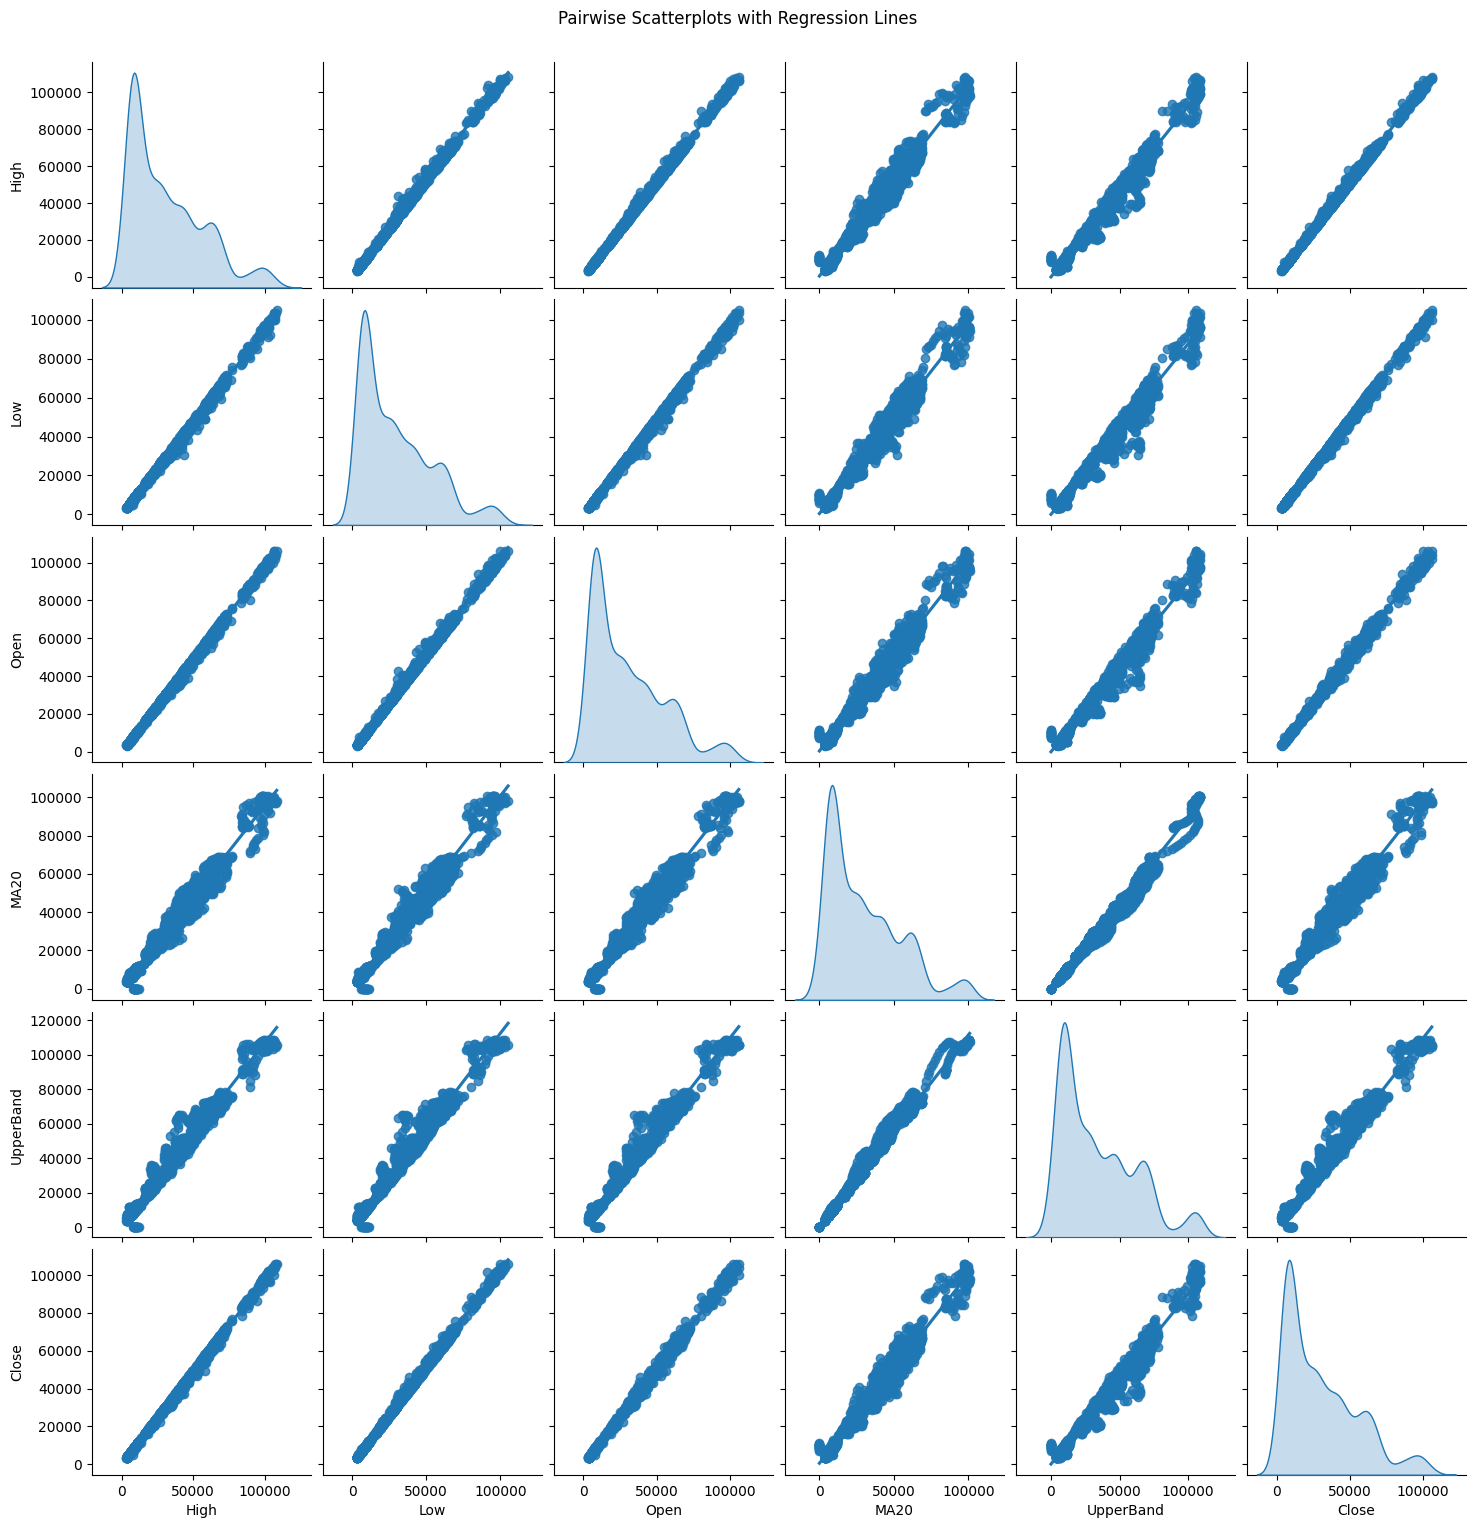

In [77]:
# Select top 5 features correlated with 'Close' (excluding 'Close' itself)
top_features = close_corr.index[1:6]

# Pairplot
sns.pairplot(df, vars=top_features.to_list() + ['Close'], kind='reg', diag_kind='kde')
plt.suptitle("Pairwise Scatterplots with Regression Lines", y=1.02)
plt.show()


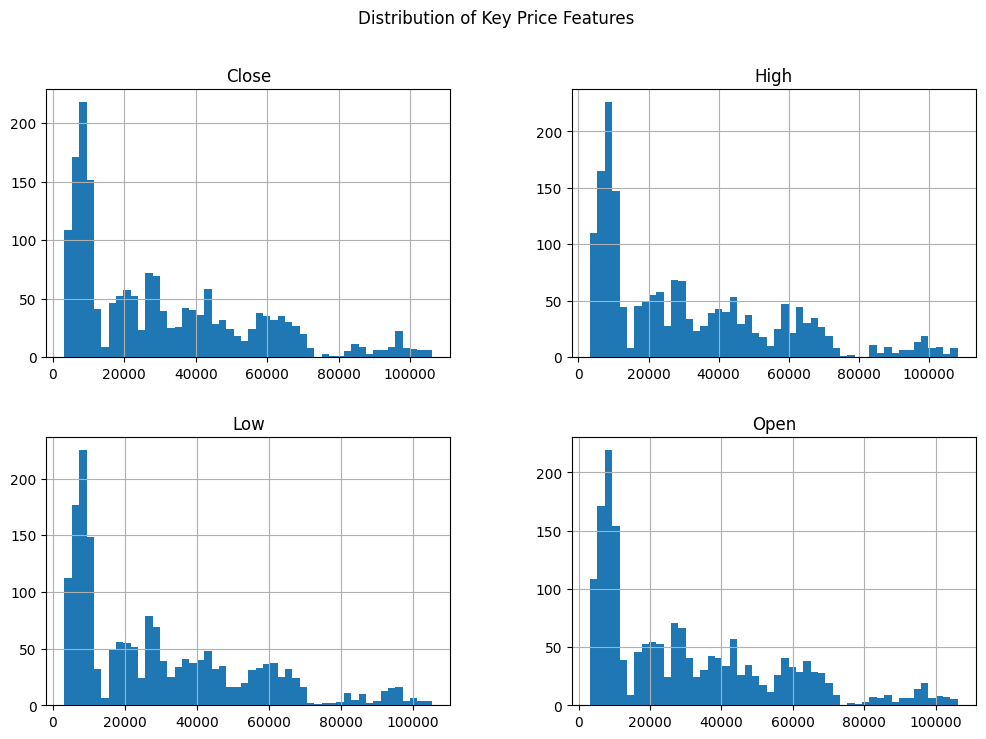

In [78]:
df[['Close', 'High', 'Low', 'Open']].hist(bins=50, figsize=(12,8))
plt.suptitle("Distribution of Key Price Features")
plt.show()

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1804 non-null   object 
 1   Close                 1804 non-null   float64
 2   High                  1804 non-null   float64
 3   Low                   1804 non-null   float64
 4   Open                  1804 non-null   float64
 5   Volume                1804 non-null   int64  
 6   value                 1804 non-null   int64  
 7   value_classification  1804 non-null   object 
 8   timestamp             1804 non-null   int64  
 9   US Dollar Index       1804 non-null   float64
 10  Federal Funds Rate    1804 non-null   float64
 11  SMA50                 1804 non-null   float64
 12  SMA200                1804 non-null   float64
 13  delta                 1804 non-null   float64
 14  gain                  1804 non-null   float64
 15  loss                 

In [80]:
print(df['value_classification'].value_counts())

value_classification
Fear             535
Greed            454
Extreme Fear     375
Neutral          248
Extreme Greed    192
Name: count, dtype: int64


In [81]:
# Ordinal encode 'value_classification'
value_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
df['value_classification'] = df['value_classification'].map(value_map)

In [82]:
# Drop non-feature column
df = df.drop(columns=['Date'])

In [99]:
# Define features and target
features_to_exclude = ['High', 'Low', 'Open']
X = df.drop(columns=features_to_exclude + ['Close'])  # drop also Close from features
y = df['Close']

In [100]:
# ---------- 1. Correlation ----------
correlation = df.drop(columns=features_to_exclude).corr()['Close'].sort_values(ascending=False)
print("\n🔗 Correlation with Close:\n", correlation)



🔗 Correlation with Close:
 Close                   1.000000
MA20                    0.989162
UpperBand               0.988977
LowerBand               0.977902
SMA50                   0.967654
SMA200                  0.890860
avg_gain                0.819176
timestamp               0.788282
stddev                  0.748117
avg_loss                0.729781
Volume                  0.557710
value                   0.382091
value_classification    0.377159
Federal Funds Rate      0.371965
gain                    0.366122
US Dollar Index         0.355654
loss                    0.318833
RSI                     0.071099
delta                   0.047321
Daily_Return            0.022740
rs                     -0.011016
Name: Close, dtype: float64


In [101]:
# ---------- 2. Mutual Information ----------
mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\n📊 Mutual Information Scores:\n", mi_series)


📊 Mutual Information Scores:
 timestamp               2.890736
UpperBand               2.371902
MA20                    2.316657
SMA50                   2.253713
LowerBand               2.187735
SMA200                  2.180320
Federal Funds Rate      1.713176
US Dollar Index         1.170796
avg_gain                1.119845
stddev                  1.105632
avg_loss                0.919621
Volume                  0.679226
value                   0.673560
value_classification    0.423392
delta                   0.334670
rs                      0.263533
RSI                     0.212006
gain                    0.184599
loss                    0.145034
Daily_Return            0.047220
dtype: float64


In [102]:
# ---------- 3. Linear Regression ----------
linreg = LinearRegression()
linreg.fit(X, y)
linreg_coefs = pd.Series(linreg.coef_, index=X.columns).sort_values(key=abs, ascending=False)
print("\n📈 Linear Regression Coefficients:\n", linreg_coefs)
print("R² Score:", r2_score(y, linreg.predict(X)))


📈 Linear Regression Coefficients:
 Daily_Return            1.023030e+03
Federal Funds Rate      2.383950e+02
value_classification   -1.338627e+02
US Dollar Index        -4.422391e+01
value                   3.522379e+01
rs                      1.538255e+01
RSI                    -9.081090e+00
avg_gain                8.999312e+00
avg_loss               -6.952137e+00
LowerBand               3.470327e-01
MA20                    3.140930e-01
UpperBand               2.811532e-01
delta                   2.230279e-01
loss                   -1.727009e-01
SMA200                  5.809238e-02
gain                    5.032706e-02
stddev                 -1.646986e-02
SMA50                  -6.555911e-04
timestamp              -8.357038e-06
Volume                  7.914287e-10
dtype: float64
R² Score: 0.9974116568999214


In [103]:
# ---------- 4. Random Forest ----------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🌲 Random Forest Importances:\n", rf_importances)


🌲 Random Forest Importances:
 MA20                    0.683647
UpperBand               0.173674
timestamp               0.061929
SMA200                  0.054384
LowerBand               0.005599
US Dollar Index         0.004703
value                   0.003912
SMA50                   0.003327
avg_gain                0.002872
RSI                     0.001675
rs                      0.001577
avg_loss                0.001063
Volume                  0.000319
stddev                  0.000316
Federal Funds Rate      0.000278
Daily_Return            0.000216
delta                   0.000174
value_classification    0.000142
gain                    0.000107
loss                    0.000086
dtype: float64


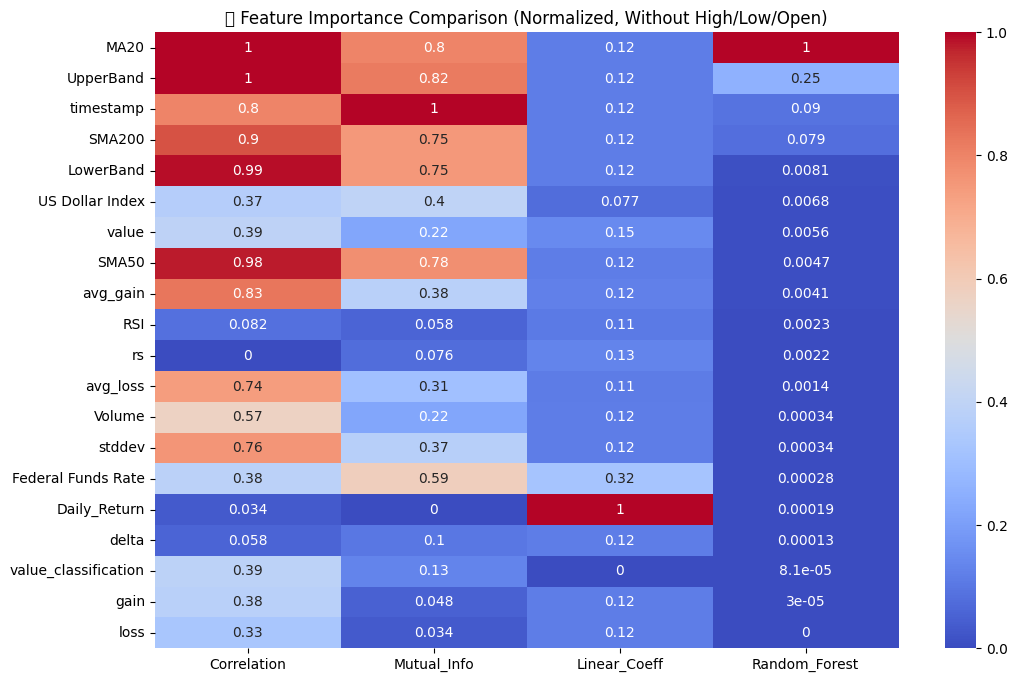

In [104]:
# ---------- 5. Combined View ----------
summary_df = pd.DataFrame({
    'Correlation': correlation.drop('Close'),
    'Mutual_Info': mi_series,
    'Linear_Coeff': linreg_coefs,
    'Random_Forest': rf_importances
})

# Normalize for heatmap
normalized_df = summary_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_df.sort_values('Random_Forest', ascending=False), annot=True, cmap='coolwarm')
plt.title('📊 Feature Importance Comparison (Normalized, Without High/Low/Open)')
plt.show()

## Model Training

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0515 - val_loss: 0.0083
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0123 - val_loss: 0.0036
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0110 - val_loss: 0.0031
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0110 - val_loss: 0.0028
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0089 - val_loss: 0.0027
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0085 - val_loss: 0.0026
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0070 - val_loss: 0.0040
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0086 - val_loss: 0.0034
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0

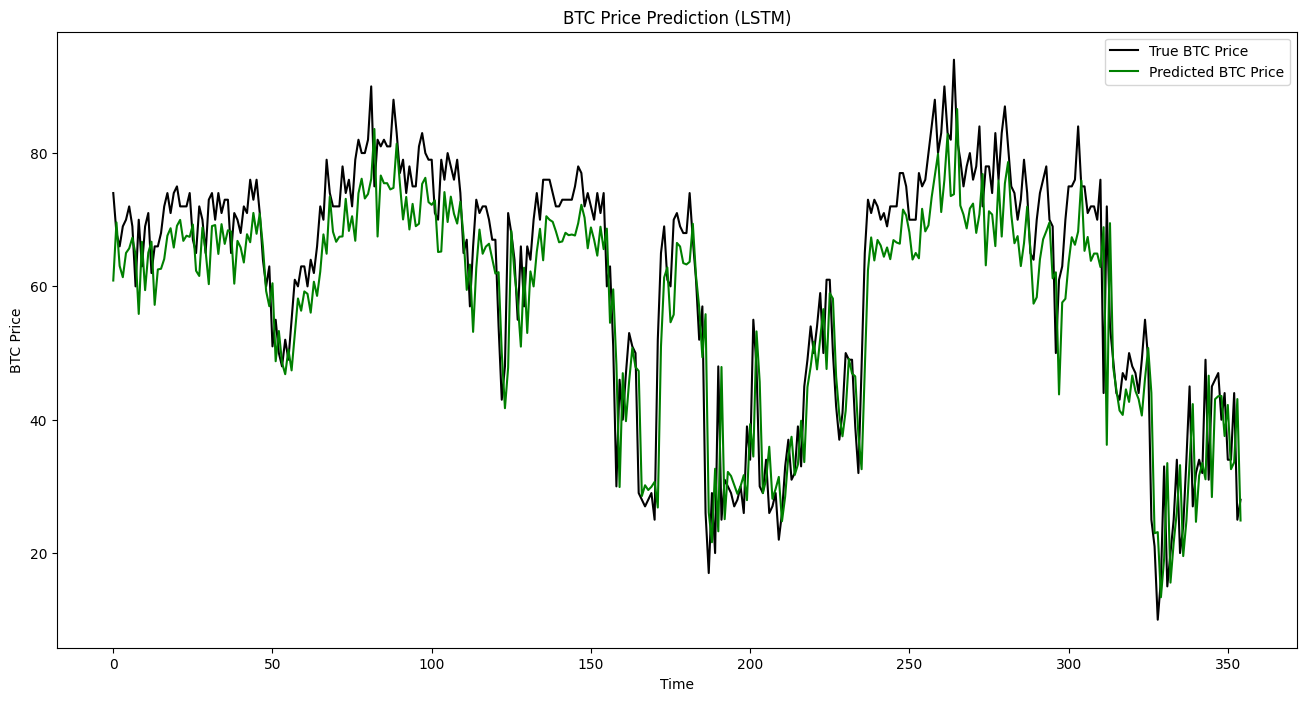

Predicted: 60.88, Actual: 74.00
Predicted: 69.60, Actual: 68.00
Predicted: 63.07, Actual: 66.00
Predicted: 61.38, Actual: 69.00
Predicted: 65.01, Actual: 70.00
Predicted: 65.70, Actual: 72.00
Predicted: 67.30, Actual: 69.00
Predicted: 64.78, Actual: 60.00
Predicted: 55.87, Actual: 70.00
Predicted: 66.68, Actual: 63.00


In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define selected features
selected_features = ['MA20', 'UpperBand', 'SMA200', 'value', 'Federal Funds Rate', 'US Dollar Index']
df_selected = df[selected_features].copy()

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_selected)

# Add 2 dummy features (zeros) to get 8 features total
dummy_padding = np.zeros((scaled_data.shape[0], 2))
scaled_data_padded = np.concatenate((scaled_data, dummy_padding), axis=1)

# Create sequences
backcandles = 30
X, y = [], []

for i in range(backcandles, len(scaled_data_padded)):
    X.append(scaled_data_padded[i - backcandles:i])
    y.append(scaled_data_padded[i, selected_features.index('value')])  # value is target

X, y = np.array(X), np.array(y)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ===================== Model =====================
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Activation
from keras import optimizers

np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

# ===================== Prediction =====================
y_pred = model.predict(X_test)

# Inverse transform prediction and test for 'value'
dummy_input_pred = np.zeros((y_pred.shape[0], len(selected_features)))
dummy_input_pred[:, selected_features.index('value')] = y_pred[:, 0]
predicted_prices = scaler.inverse_transform(dummy_input_pred)[:, selected_features.index('value')]

dummy_input_test = np.zeros((y_test.shape[0], len(selected_features)))
dummy_input_test[:, selected_features.index('value')] = y_test
true_prices = scaler.inverse_transform(dummy_input_test)[:, selected_features.index('value')]

# ===================== Visualization =====================
plt.figure(figsize=(16,8))
plt.plot(true_prices, color='black', label='True BTC Price')
plt.plot(predicted_prices, color='green', label='Predicted BTC Price')
plt.title('BTC Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# Sample predictions
for i in range(10):
    print(f"Predicted: {predicted_prices[i]:.2f}, Actual: {true_prices[i]:.2f}")



📊 Evaluation Metrics:
✅ MSE: 76.26
✅ MAE: 6.94
✅ R² Score: 0.7676


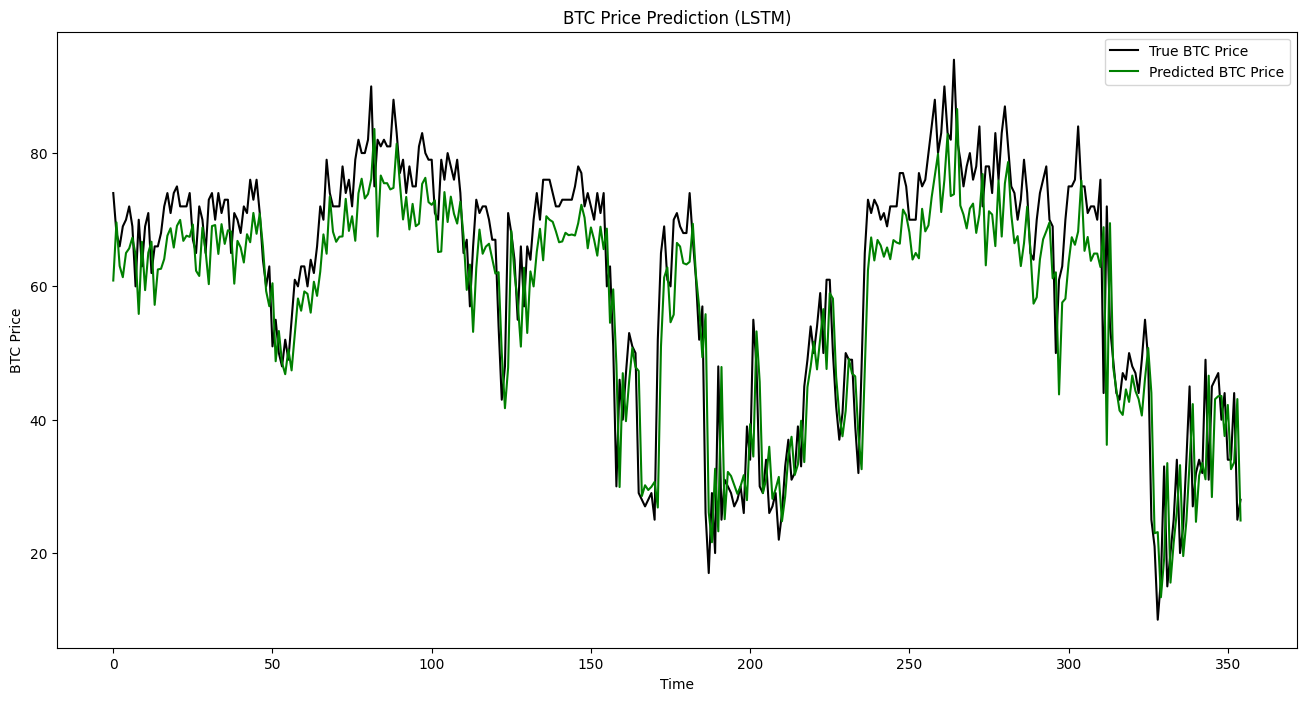


🧪 Sample Predictions:
Predicted: 60.88, Actual: 74.00
Predicted: 69.60, Actual: 68.00
Predicted: 63.07, Actual: 66.00
Predicted: 61.38, Actual: 69.00
Predicted: 65.01, Actual: 70.00
Predicted: 65.70, Actual: 72.00
Predicted: 67.30, Actual: 69.00
Predicted: 64.78, Actual: 60.00
Predicted: 55.87, Actual: 70.00
Predicted: 66.68, Actual: 63.00


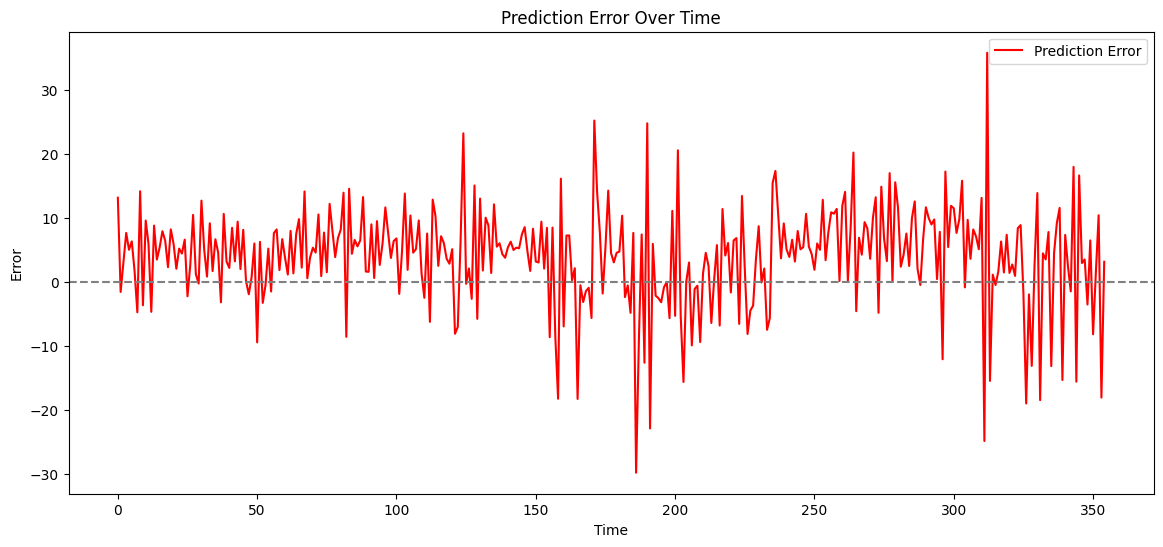


📏 Baseline MSE (Prev Day's Price): 59.10
📈 LSTM Model MSE: 75.99

💾 Model saved as 'btc_lstm_model.h5'


"\nimport plotly.graph_objs as go\n\nfig = go.Figure()\nfig.add_trace(go.Scatter(y=true_prices, name='Actual BTC', line=dict(color='black')))\nfig.add_trace(go.Scatter(y=predicted_prices, name='Predicted BTC', line=dict(color='green')))\nfig.update_layout(title='BTC Price Prediction (Interactive)', xaxis_title='Time', yaxis_title='BTC Price')\nfig.show()\n"

In [131]:
# ========== Inverse Transform Predictions ==========
# Create dummy arrays to inverse transform only the 'value' feature
dummy_input_pred = np.zeros((y_pred.shape[0], len(selected_features)))
dummy_input_pred[:, selected_features.index('value')] = y_pred[:, 0]
predicted_prices = scaler.inverse_transform(dummy_input_pred)[:, selected_features.index('value')]

dummy_input_test = np.zeros((y_test.shape[0], len(selected_features)))
dummy_input_test[:, selected_features.index('value')] = y_test
true_prices = scaler.inverse_transform(dummy_input_test)[:, selected_features.index('value')]

# ========== Evaluation Metrics ==========
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(true_prices, predicted_prices)
mae = mean_absolute_error(true_prices, predicted_prices)
r2 = r2_score(true_prices, predicted_prices)

print(f"\n📊 Evaluation Metrics:")
print(f"✅ MSE: {mse:.2f}")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ R² Score: {r2:.4f}")

# ========== Visualization ==========
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(true_prices, color='black', label='True BTC Price')
plt.plot(predicted_prices, color='green', label='Predicted BTC Price')
plt.title('BTC Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

# ========== Sample Predictions ==========
print("\n🧪 Sample Predictions:")
for i in range(10):
    print(f"Predicted: {predicted_prices[i]:.2f}, Actual: {true_prices[i]:.2f}")

# ========== Error Plot ==========
errors = true_prices - predicted_prices
plt.figure(figsize=(14, 6))
plt.plot(errors, label='Prediction Error', color='red')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Prediction Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()

# ========== Baseline Comparison ==========
baseline = true_prices[:-1]
model_pred = predicted_prices[1:]

mse_baseline = mean_squared_error(true_prices[1:], baseline)
mse_model = mean_squared_error(true_prices[1:], model_pred)

print(f"\n📏 Baseline MSE (Prev Day's Price): {mse_baseline:.2f}")
print(f"📈 LSTM Model MSE: {mse_model:.2f}")

# ========== Optional: Save Model ==========
model.save('btc_lstm_model.h5')
print("\n💾 Model saved as 'btc_lstm_model.h5'")

# ========== Optional: Interactive Plot (Plotly) ==========
# Uncomment below to use
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=true_prices, name='Actual BTC', line=dict(color='black')))
fig.add_trace(go.Scatter(y=predicted_prices, name='Predicted BTC', line=dict(color='green')))
fig.update_layout(title='BTC Price Prediction (Interactive)', xaxis_title='Time', yaxis_title='BTC Price')
fig.show()
